--------------------------------------------------------------------------------------------------------------
# Bibliotecas utilizadas 
--------------------------------------------------------------------------------------------------------------

In [1]:
import ipywidgets as widgets
from IPython.display import display, HTML
import oracledb
import pandas as pd
from tabulate import tabulate
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter

--------------------------------------------------------------------------------------------------------------
# Área de Cadastro
--------------------------------------------------------------------------------------------------------------

### CADASTRO

Este código cria uma interface interativa com ipywidgets para coletar dados de usuários, incluindo nome, e-mail, especialidade, localização, data de nascimento, senha e tipo de usuário. Após preencher os campos e acionar o botão de inserção, os dados são validados e inseridos no banco de dados Oracle, com a senha sendo hasheada para segurança. Após a inserção, o conteúdo da tabela USUARIOS é exibido em formato HTML.

In [2]:
# Widgets para cada campo da tabela
nm_usuario = widgets.Text(description='Nome Usuário:')
ds_email = widgets.Text(description='Email:')
ds_especialidade = widgets.Text(description='Especialidade:')
ds_localizacao = widgets.Text(description='Localização:')
dt_nascimento = widgets.DatePicker(description='Nascimento:')
ps_usuario = widgets.Textarea(description='Senha:')
tp_usuario = widgets.Dropdown(
    options=['Professor', 'Aluno'],
    description='Tipo Usuário:'
)

# Função para hashear a senha
def hash_password(password):
    import hashlib
    return hashlib.sha256(password.encode()).hexdigest()

# Função para inserir os dados no banco de dados e exibir a tabela
def inserir_dados(b):
    # Verificar se todos os campos estão preenchidos
    if not nm_usuario.value or not ds_email.value or not ds_especialidade.value or not ds_localizacao.value or not dt_nascimento.value or not ps_usuario.value or not tp_usuario.value:
        print("Por favor, preencha todos os campos.")
        return
    
    with oracledb.connect(
        user='RM99667',
        password='260903',
        dsn='oracle.fiap.com.br:1521/ORCL',
        config_dir='C:\\Users\\victo\\Oracle\\network\\admin',
    ) as connection:
        with connection.cursor() as cursor:
            # Garantir que a data esteja no formato correto
            data_nascimento = dt_nascimento.value.strftime('%Y-%m-%d')
            # Hashear a senha
            hashed_password = hash_password(ps_usuario.value)
            cursor.execute("""
                INSERT INTO RM99210.USUARIOS (
                    ID_USUARIO, NM_USUARIO, DS_EMAIL, DS_ESPECIALIDADE,
                    DS_LOCALIZACAO, DT_NASCIMENTO, PS_USUARIO, TP_USUARIO
                ) VALUES (
                    RM99210.SEQ_USUARIOS_ID.NEXTVAL, :1, :2, :3, :4, TO_DATE(:5, 'YYYY-MM-DD'), :6, :7
                )
            """, (
                nm_usuario.value, ds_email.value, ds_especialidade.value,
                ds_localizacao.value, data_nascimento, hashed_password, tp_usuario.value
            ))
            connection.commit()
    print("Dados inseridos com sucesso!")
    exibir_tabela()

# Função para exibir a tabela
def exibir_tabela():
    sql_text = """
    SELECT * FROM RM99210.USUARIOS
    """
    with oracledb.connect(
        user='RM99667',
        password='260903',
        dsn='oracle.fiap.com.br:1521/ORCL',
        config_dir='C:\\Users\\victo\\Oracle\\network\\admin',
    ) as connection:
        with connection.cursor() as cursor:
            # Fetch all rows from the executed query
            rows = cursor.execute(sql_text).fetchall()
            # Fetch column names
            column_names = [col[0] for col in cursor.description]
    # Convert the results to a DataFrame
    df = pd.DataFrame(rows, columns=column_names)
    # Display the DataFrame as an HTML table
    display(HTML(df.to_html(index=False, classes='table table-striped table-bordered')))

# Botão para acionar a inserção
botao_inserir = widgets.Button(description='Inserir Dados')
botao_inserir.on_click(inserir_dados)

# Exibir widgets
display(nm_usuario, ds_email, ds_especialidade, ds_localizacao, dt_nascimento, ps_usuario, tp_usuario, botao_inserir)

Text(value='', description='Nome Usuário:')

Text(value='', description='Email:')

Text(value='', description='Especialidade:')

Text(value='', description='Localização:')

DatePicker(value=None, description='Nascimento:', step=1)

Textarea(value='', description='Senha:')

Dropdown(description='Tipo Usuário:', options=('Professor', 'Aluno'), value='Professor')

Button(description='Inserir Dados', style=ButtonStyle())

### LOGIN

Este código implementa uma interface de login usando ipywidgets. Ele coleta o nome de usuário e a senha, hasheia a senha usando o algoritmo SHA-256 e verifica as credenciais no banco de dados Oracle. Se o nome de usuário e a senha forem válidos, uma mensagem de sucesso é exibida; caso contrário, uma mensagem de erro é mostrada. O código também valida se os campos estão preenchidos antes de processar o login.

In [3]:
# Function to hash the password
def hash_password(password):
    return hashlib.sha256(password.encode()).hexdigest()

# Function to log in the user
def login(username, password):
    hashed_password = hash_password(password)
    with oracledb.connect(
        user='RM99667',
        password='260903',
        dsn='oracle.fiap.com.br:1521/ORCL',
        config_dir='C:\\Users\\victo\\Oracle\\network\\admin',
    ) as connection:
        with connection.cursor() as cursor:
            cursor.execute("""
                SELECT COUNT(*) FROM RM99210.USUARIOS
                WHERE NM_USUARIO = :1 AND PS_USUARIO = :2
            """, (username, hashed_password))
            result = cursor.fetchone()
            if result[0] > 0:
                print("Login successful!")
            else:
                print("Invalid username or password.")

# Widgets for username and password
username_widget = widgets.Text(description='Username:')
password_widget = widgets.Password(description='Password:')
login_button = widgets.Button(description='Login')
error_label = widgets.Label(value='', layout=widgets.Layout(color='red'))

# Function to handle login button click
def on_login_button_clicked(b):
    username = username_widget.value.strip()
    password = password_widget.value.strip()
    
    # Verificar se todos os campos estão preenchidos
    if not username or not password:
        error_label.value = "Por favor, preencha todos os campos."
        return
    
    error_label.value = ''  # Clear any previous error message
    login(username, password)

# Attach the click event to the login button
login_button.on_click(on_login_button_clicked)

# Display the widgets
display(username_widget, password_widget, login_button, error_label)

Text(value='', description='Username:')

Password(description='Password:')

Button(description='Login', style=ButtonStyle())

Label(value='')

--------------------------------------------------------------------------------------------------------------
# Área do Professor e suas funcionalidades
--------------------------------------------------------------------------------------------------------------

### ADICIONANDO NOTAS

Este código cria uma interface interativa com ipywidgets para inserir registros na tabela Historico_Notas em um banco de dados Oracle. Ele coleta dados como data, nome do aluno, matéria, período e a média dos alunos. Quando o botão "Insert" é acionado, os valores são validados e, se estiverem completos, o registro é inserido na tabela do banco de dados. Caso ocorra um erro, ele é tratado e exibido.

In [4]:
# Função para inserir dados na tabela Historico_Notas
def insert_historico_notas(data, nome_aluno, materia, periodo, medias_dos_alunos):
    try:
        # Conectar ao banco de dados Oracle
        with oracledb.connect(
            user='RM99667',
            password='260903',
            dsn='oracle.fiap.com.br:1521/ORCL',
            config_dir='C:\\Users\\victo\\Oracle\\network\\admin',
        ) as connection:
            with connection.cursor() as cursor:
                # Executar a instrução SQL para inserir um novo registro
                cursor.execute("""
                    INSERT INTO RM99210.Historico_Notas (DATA, NOME_ALUNO, MATERIA, PERIODO, MEDIAS_DOS_ALUNOS)
                    VALUES (:1, :2, :3, :4, :5)
                """, (data, nome_aluno, materia, periodo, medias_dos_alunos))
                # Confirmar a transação
                connection.commit()
                print("Record inserted successfully!")
    except oracledb.DatabaseError as e:
        error, = e.args
        print(f"Database error: {error.message}")

# Widgets para inserir dados
data_widget = widgets.DatePicker(description='Data:')
nome_aluno_widget = widgets.Text(description='Nome Aluno:')
materia_widget = widgets.Text(description='Materia:')
periodo_widget = widgets.Dropdown(
    options=['Manhã', 'Noite'],
    description='Periodo:'
)
medias_dos_alunos_widget = widgets.FloatText(description='Media:', step=0.01)
insert_button = widgets.Button(description='Insert')
error_label = widgets.Label(value='', layout=widgets.Layout(color='red'))

# Função para lidar com o clique do botão de inserção
def on_insert_button_clicked(b):
    data = data_widget.value
    nome_aluno = nome_aluno_widget.value.strip()
    materia = materia_widget.value.strip()
    periodo = periodo_widget.value
    medias_dos_alunos = round(medias_dos_alunos_widget.value, 2)
    
    # Verificar se todos os campos estão preenchidos
    if not data or not nome_aluno or not materia or not periodo or medias_dos_alunos is None:
        error_label.value = "Por favor, preencha todos os campos."
        return
    
    error_label.value = ''  # Clear any previous error message
    insert_historico_notas(data, nome_aluno, materia, periodo, medias_dos_alunos)

# Anexar o evento de clique ao botão de inserção
insert_button.on_click(on_insert_button_clicked)

# Exibir os widgets
print("Insert Record:")
display(data_widget, nome_aluno_widget, materia_widget, periodo_widget, medias_dos_alunos_widget, insert_button, error_label)

Insert Record:


DatePicker(value=None, description='Data:', step=1)

Text(value='', description='Nome Aluno:')

Text(value='', description='Materia:')

Dropdown(description='Periodo:', options=('Manhã', 'Noite'), value='Manhã')

FloatText(value=0.0, description='Media:', step=0.01)

Button(description='Insert', style=ButtonStyle())

Label(value='')

### Analise do Professor sobre as Médias dos Alunos por Período de Tempo

Este código realiza uma consulta em um banco de dados Oracle para obter dados de médias de alunos ao longo do tempo e os exibe em um gráfico de barras. Ele usa oracledb para se conectar ao banco de dados, recupera os dados da tabela Historico_Notas, e utiliza pandas para manipulação dos dados e matplotlib para criar o gráfico. As médias dos alunos são agrupadas por data e exibidas no gráfico, com as datas no eixo x e as médias no eixo y, permitindo uma visualização clara da evolução ao longo do tempo.

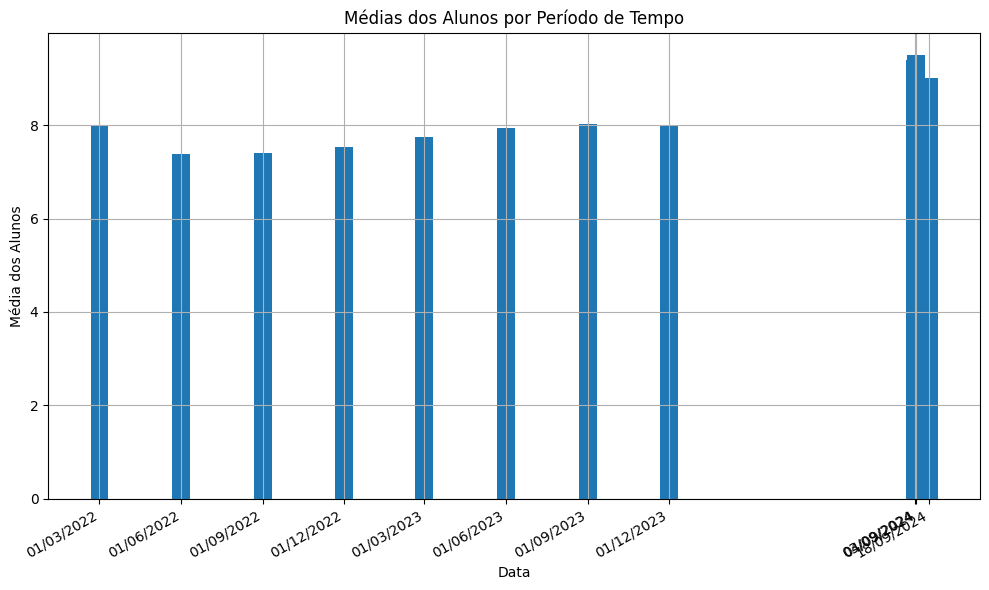

Done!!


In [5]:
# Texto SQL que será executado
sql_text = """
SELECT DATA, MEDIAS_DOS_ALUNOS FROM RM99210.Historico_Notas
"""

# Aqui criamos uma conexão Python, objeto cursor e executamos a instrução usando Cursor.execute().
# Conexões e cursores devem ser liberados quando não são mais necessários.
# Eles são fechados automaticamente quando a variável que os referencia sai do escopo (e nenhuma outra referência é mantida).
# O bloco `with` é uma maneira conveniente de garantir isso.
with oracledb.connect(
  user='RM99667',
  password='260903',
  dsn='oracle.fiap.com.br:1521/ORCL',
  config_dir='C:\\Users\\victo\\Oracle\\network\\admin',
) as connection:
    with connection.cursor() as cursor:
        # Buscar todas as linhas da consulta executada
        rows = cursor.execute(sql_text).fetchall()
        # Buscar nomes das colunas
        column_names = [col[0] for col in cursor.description]

# Converter os dados para um DataFrame
df = pd.DataFrame(rows, columns=column_names)

# Garantir que a coluna 'DATA' esteja no formato datetime
df['DATA'] = pd.to_datetime(df['DATA'])

# Agrupar por 'DATA' e calcular a média de 'MEDIAS_DOS_ALUNOS'
df_grouped = df.groupby('DATA').mean().reset_index()

# Plotar os dados como um gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df_grouped['DATA'], df_grouped['MEDIAS_DOS_ALUNOS'], width=20)  # Ajustar a largura para melhor espaçamento
plt.title('Médias dos Alunos por Período de Tempo')
plt.xlabel('Data')
plt.ylabel('Média dos Alunos')
plt.grid(True)
plt.xticks(df_grouped['DATA'], df_grouped['DATA'].dt.strftime('%d/%m/%Y'), rotation=45, ha='right', fontsize=10)  # Formatar datas e ajustar o tamanho da fonte
plt.gcf().autofmt_xdate()  # Auto formatar rótulos de data
plt.tight_layout()
plt.show()

print("Done!!")

### Notas - Manhã vs Noite 

Este código consulta o banco de dados Oracle para obter as médias de notas dos alunos até 01/12/2023 e cria um gráfico comparando as notas dos períodos da manhã e noite. Os dados são organizados com pandas e o gráfico mostra a evolução das médias para cada período ao longo do tempo, facilitando a comparação de desempenho.

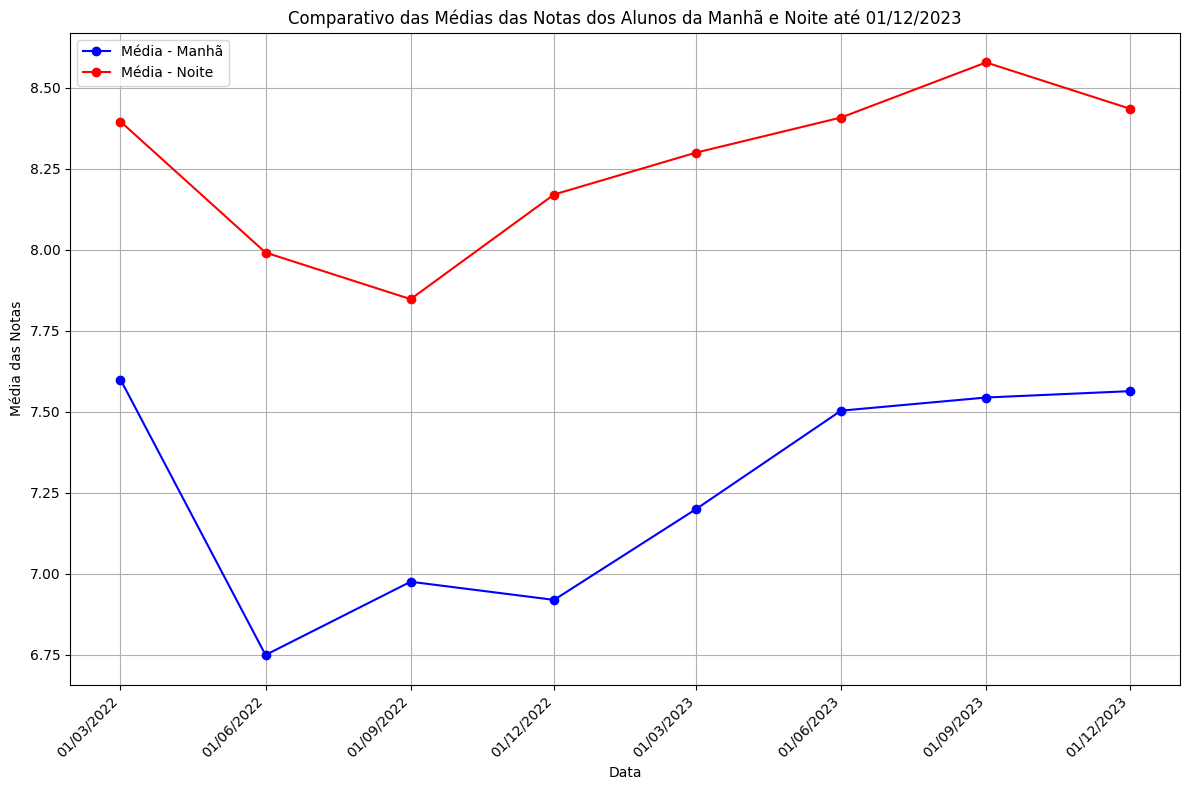

Done!!


In [6]:
# Texto SQL que será executado
sql_text = """
SELECT DATA, MEDIAS_DOS_ALUNOS, PERIODO FROM RM99210.Historico_Notas
WHERE DATA <= TO_DATE('01-12-2023', 'DD-MM-YYYY')
"""

# Aqui criamos uma conexão Python, objeto cursor e executamos a instrução usando Cursor.execute().
# Conexões e cursores devem ser liberados quando não são mais necessários.
# Eles são fechados automaticamente quando a variável que os referencia sai do escopo (e nenhuma outra referência é mantida).
# O bloco `with` é uma maneira conveniente de garantir isso.
with oracledb.connect(
  user='RM99667',
  password='260903',
  dsn='oracle.fiap.com.br:1521/ORCL',
  config_dir='C:\\Users\\victo\\Oracle\\network\\admin',
) as connection:
    with connection.cursor() as cursor:
        # Buscar todas as linhas da consulta executada
        rows = cursor.execute(sql_text).fetchall()
        # Buscar nomes das colunas
        column_names = [col[0] for col in cursor.description]

# Converter os dados para um DataFrame
df = pd.DataFrame(rows, columns=column_names)

# Garantir que a coluna 'DATA' esteja no formato datetime
df['DATA'] = pd.to_datetime(df['DATA'])

# Garantir que a coluna 'MEDIAS_DOS_ALUNOS' seja numérica
df['MEDIAS_DOS_ALUNOS'] = pd.to_numeric(df['MEDIAS_DOS_ALUNOS'], errors='coerce')

# Remover linhas com valores NaN em 'MEDIAS_DOS_ALUNOS'
df = df.dropna(subset=['MEDIAS_DOS_ALUNOS'])

# Separar dados para os períodos da manhã e da noite
df_morning = df[df['PERIODO'] == 'Manhã']
df_night = df[df['PERIODO'] == 'Noite']

# Agrupar por 'DATA' e calcular a média de 'MEDIAS_DOS_ALUNOS' para cada período
df_morning_grouped = df_morning.groupby('DATA')['MEDIAS_DOS_ALUNOS'].mean().reset_index()
df_night_grouped = df_night.groupby('DATA')['MEDIAS_DOS_ALUNOS'].mean().reset_index()

# Plotar os resultados para ambos os períodos em um gráfico
plt.figure(figsize=(12, 8))
plt.plot(df_morning_grouped['DATA'], df_morning_grouped['MEDIAS_DOS_ALUNOS'], marker='o', linestyle='-', color='b', label='Média - Manhã')
plt.plot(df_night_grouped['DATA'], df_night_grouped['MEDIAS_DOS_ALUNOS'], marker='o', linestyle='-', color='r', label='Média - Noite')
plt.title('Comparativo das Médias das Notas dos Alunos da Manhã e Noite até 01/12/2023')
plt.xlabel('Data')
plt.ylabel('Média das Notas')
plt.grid(True)
plt.xticks(df_morning_grouped['DATA'], df_morning_grouped['DATA'].dt.strftime('%d/%m/%Y'), rotation=45, ha='right', fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()

print("Done!!")

### Notas dos alunos em diferença de materia 

Este código consulta o banco de dados Oracle para obter as médias de notas dos alunos por matéria. Os dados são organizados em um DataFrame e agrupados por data e matéria. Em seguida, o gráfico é gerado, mostrando a evolução das médias de notas para cada matéria ao longo do tempo, com uma linha para cada matéria, permitindo fácil comparação entre elas.

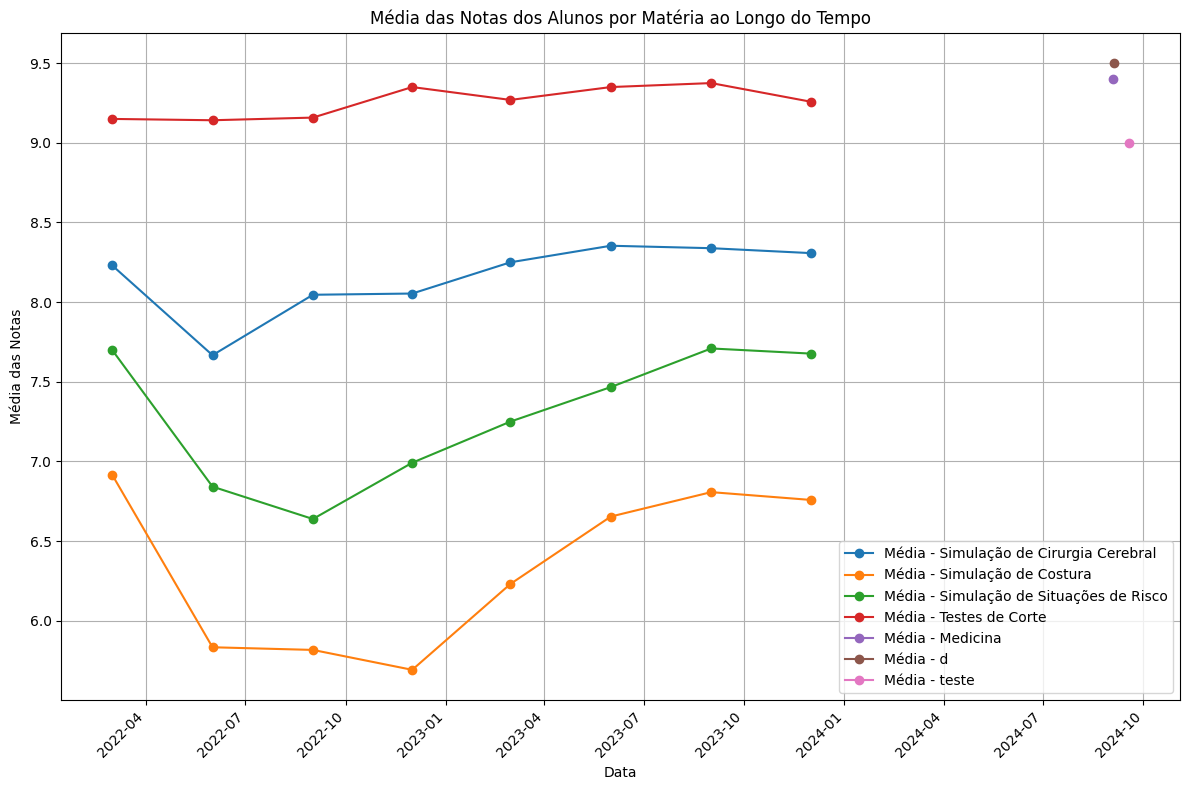

In [7]:
# this is the SQL text that will be executed
sql_text = """
SELECT DATA, MEDIAS_DOS_ALUNOS, MATERIA FROM RM99210.Historico_Notas
"""

# here we create a python connection,cursor object and execute the statement using  Cursor.execute().
# connections and cursors should be released when they are no longer needed.
# closed automatically when the variable referencing it goes out of scope (and no further references are retained).
# `with` block is a convenient way to ensure this
with oracledb.connect(
  user='RM99667',
  password='260903',
  dsn='oracle.fiap.com.br:1521/ORCL',
  config_dir='C:\\Users\\victo\\Oracle\\network\\admin',
) as connection:
    with connection.cursor() as cursor:
        # Fetch all rows from the executed query
        rows = cursor.execute(sql_text).fetchall()
        # Fetch column names
        column_names = [col[0] for col in cursor.description]

# Convert the data to a DataFrame
df = pd.DataFrame(rows, columns=column_names)

# Ensure the 'DATA' column is in datetime format
df['DATA'] = pd.to_datetime(df['DATA'])

# Ensure the 'MEDIAS_DOS_ALUNOS' column is numeric
df['MEDIAS_DOS_ALUNOS'] = pd.to_numeric(df['MEDIAS_DOS_ALUNOS'], errors='coerce')

# Drop rows with NaN values in 'MEDIAS_DOS_ALUNOS'
df = df.dropna(subset=['MEDIAS_DOS_ALUNOS'])

# Group by 'DATA' and 'MATERIA' and calculate the mean of 'MEDIAS_DOS_ALUNOS'
df_grouped = df.groupby(['DATA', 'MATERIA'])['MEDIAS_DOS_ALUNOS'].mean().reset_index()

# Plotting the results for each subject
plt.figure(figsize=(12, 8))
for materia in df_grouped['MATERIA'].unique():
    df_materia = df_grouped[df_grouped['MATERIA'] == materia]
    plt.plot(df_materia['DATA'], df_materia['MEDIAS_DOS_ALUNOS'], marker='o', linestyle='-', label=f'Média - {materia}')

plt.title('Média das Notas dos Alunos por Matéria ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Média das Notas')
plt.grid(True)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()

### Teste de Campo

Neste código, utilizamos os dados reais dos testes realizados em nosso jogo (o vídeo demonstrando o funcionamento está anexado ao documento). Com esses dados, analisamos a melhoria no desempenho dos usuários à medida que avançavam nos exercícios propostos pelo jogo. Em seguida, plotamos um gráfico com as notas e suas respectivas porcentagens de progresso.

['nome', 'tentativa', 'tempo']
nome          object
tentativa      int64
tempo        float64
dtype: object
      nome  tentativa    tempo  evolucao_percentual
20   Andre          1  125.015             0.000000
21   Andre          2  100.023           -19.991201
22   Andre          3   85.032           -14.987553
23   Andre          4   79.052            -7.032647
24   Andre          5   72.021            -8.894146
15  Felipe          1  100.032             0.000000
16  Felipe          2   92.042            -7.987444
17  Felipe          3   91.012            -1.119054
18  Felipe          4   75.015           -17.576803
19  Felipe          5   64.020           -14.657069
10   Julia          1   99.044             0.000000
11   Julia          2   85.012           -14.167441
12   Julia          3   76.023           -10.573801
13   Julia          4   61.033           -19.717717
14   Julia          5   57.025            -6.566939
5     Luis          1  110.025             0.000000
6     Lu

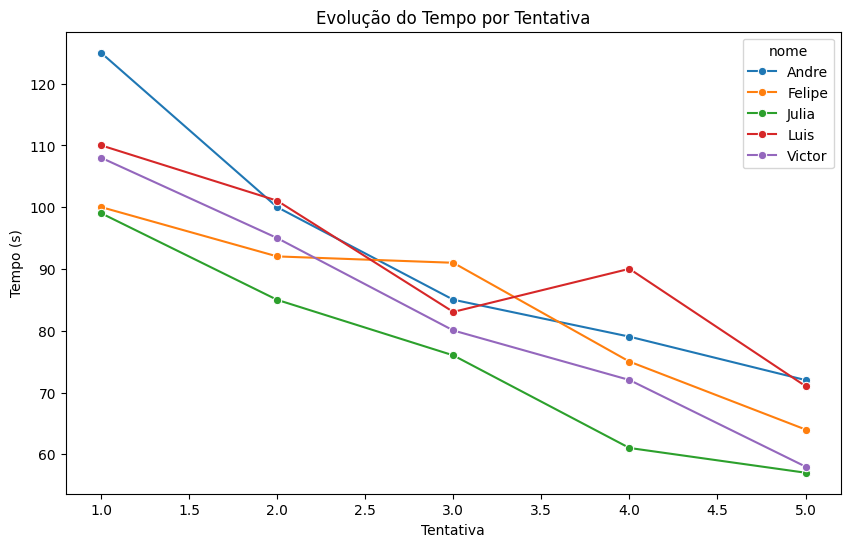

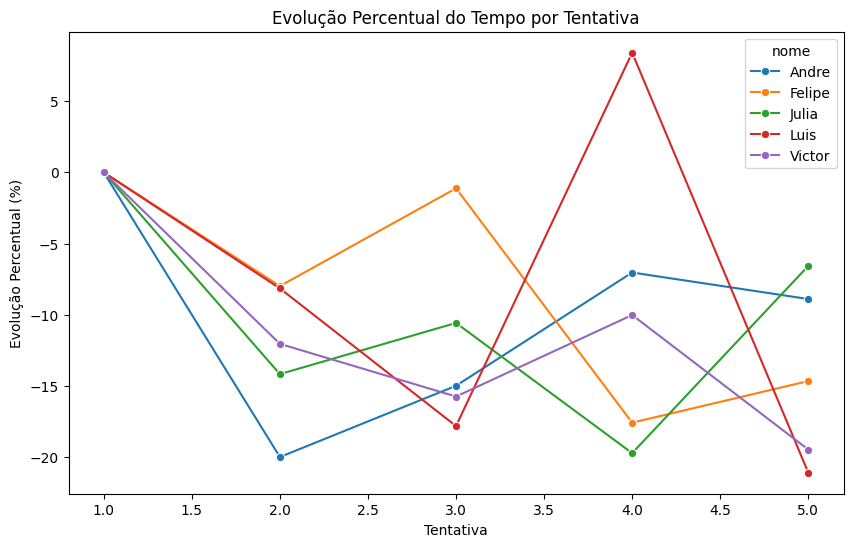

In [8]:
# Função para converter tempo no formato MM:SS:MS para segundos
def time_to_seconds(time_str):
    m, s, ms = map(int, time_str.split(':'))
    return m * 60 + s + ms / 1000

# Criar DataFrame a partir do arquivo CSV com delimitador ponto e vírgula
df = pd.read_csv('tempos.csv', delimiter=';')

# Mostrar as colunas do DataFrame como uma lista
print(list(df.columns))

# Remover espaços em branco e caracteres especiais da coluna 'tempo'
df['tempo'] = df['tempo'].str.strip()

# Converter a coluna 'tempo' para segundos
df['tempo'] = df['tempo'].apply(time_to_seconds)

# Mostrar os tipos de dados para verificar a conversão
print(df.dtypes)

# Ordenar o DataFrame por nome e tentativa
df = df.sort_values(by=['nome', 'tentativa'])

# Calcular a evolução percentual do tempo para cada pessoa
df['evolucao_percentual'] = df.groupby('nome')['tempo'].pct_change() * 100

# Preencher valores NaN resultantes da primeira tentativa com 0
df['evolucao_percentual'] = df['evolucao_percentual'].fillna(0)

# Mostrar o DataFrame atualizado
print(df)

# Calcular a média da evolução percentual total
media_evolucao_percentual_total = df['evolucao_percentual'].mean()

# Remover o sinal negativo e formatar com 3 casas decimais e o símbolo de %
media_evolucao_percentual_total = abs(media_evolucao_percentual_total)
media_evolucao_percentual_total_formatada = f"{media_evolucao_percentual_total:.3f}%"

# Mostrar a média da evolução percentual total formatada
print("Média Total da Evolução Percentual:")
print(media_evolucao_percentual_total_formatada)

# Criar gráfico de linhas para comparar a evolução do tempo de cada pessoa ao passar das tentativas
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='tentativa', y='tempo', hue='nome', marker='o')

# Adicionar título e rótulos aos eixos
plt.title('Evolução do Tempo por Tentativa')
plt.xlabel('Tentativa')
plt.ylabel('Tempo (s)')

# Mostrar o gráfico
plt.show()

# Criar gráfico de linhas para comparar a evolução percentual do tempo de cada pessoa ao passar das tentativas
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='tentativa', y='evolucao_percentual', hue='nome', marker='o')

# Adicionar título e rótulos aos eixos
plt.title('Evolução Percentual do Tempo por Tentativa')
plt.xlabel('Tentativa')
plt.ylabel('Evolução Percentual (%)')

# Mostrar o gráfico
plt.show()

### Projeção das notas dos alunos de acordo com nossos testes 

Com base nos testes realizados, projetamos as notas futuras dos alunos utilizando um avanço médio de 10% em cada etapa dos exercícios. Esse percentual foi calculado a partir dos dados reais de desempenho dos usuários, indicando uma melhoria consistente ao longo do tempo. Essa projeção permite prever o progresso dos alunos à medida que continuam utilizando a plataforma.

C:\Users\luisg\AppData\Local\Temp\ipykernel_45696\807253847.py:97: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start='2023-03-01', periods=num_periods, freq='3M')


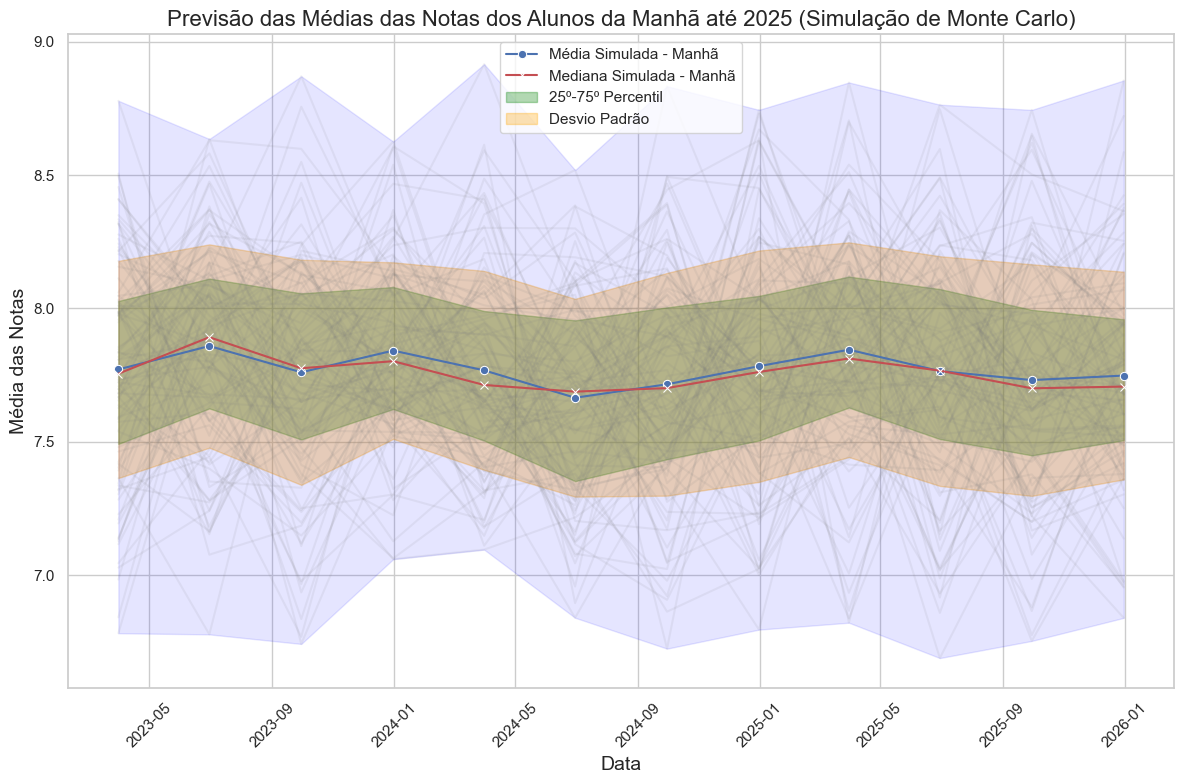

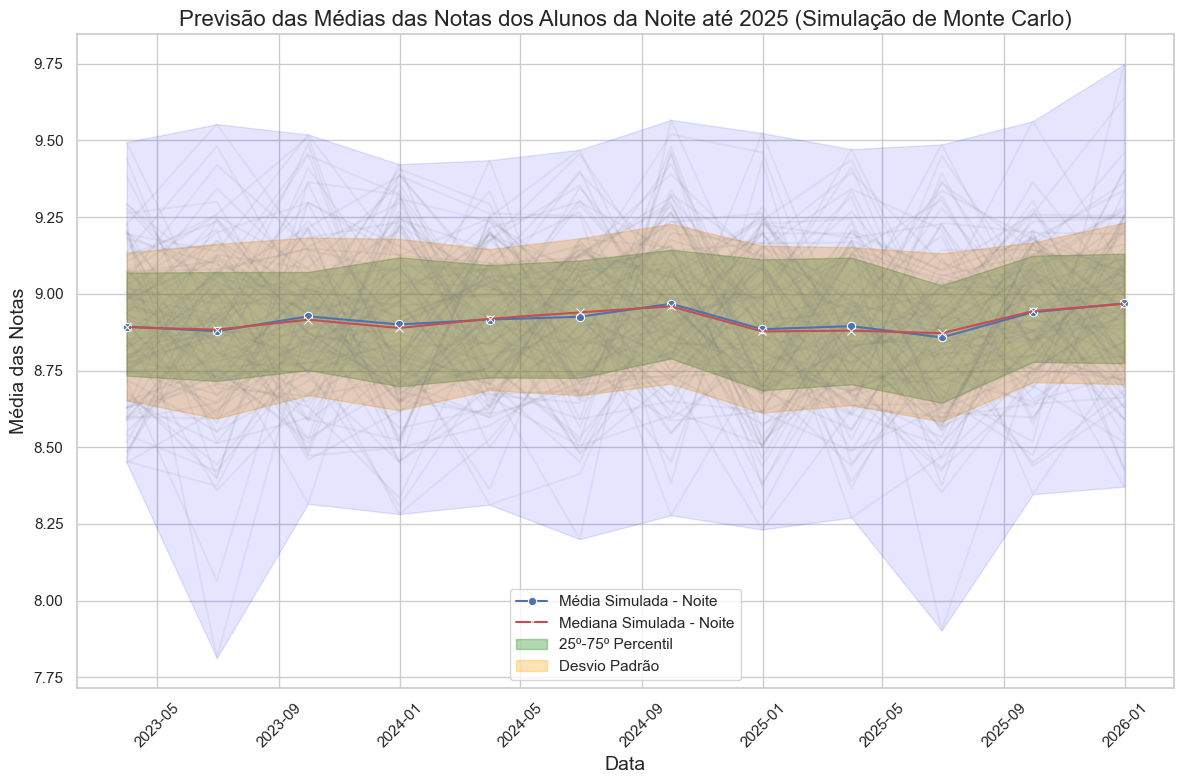

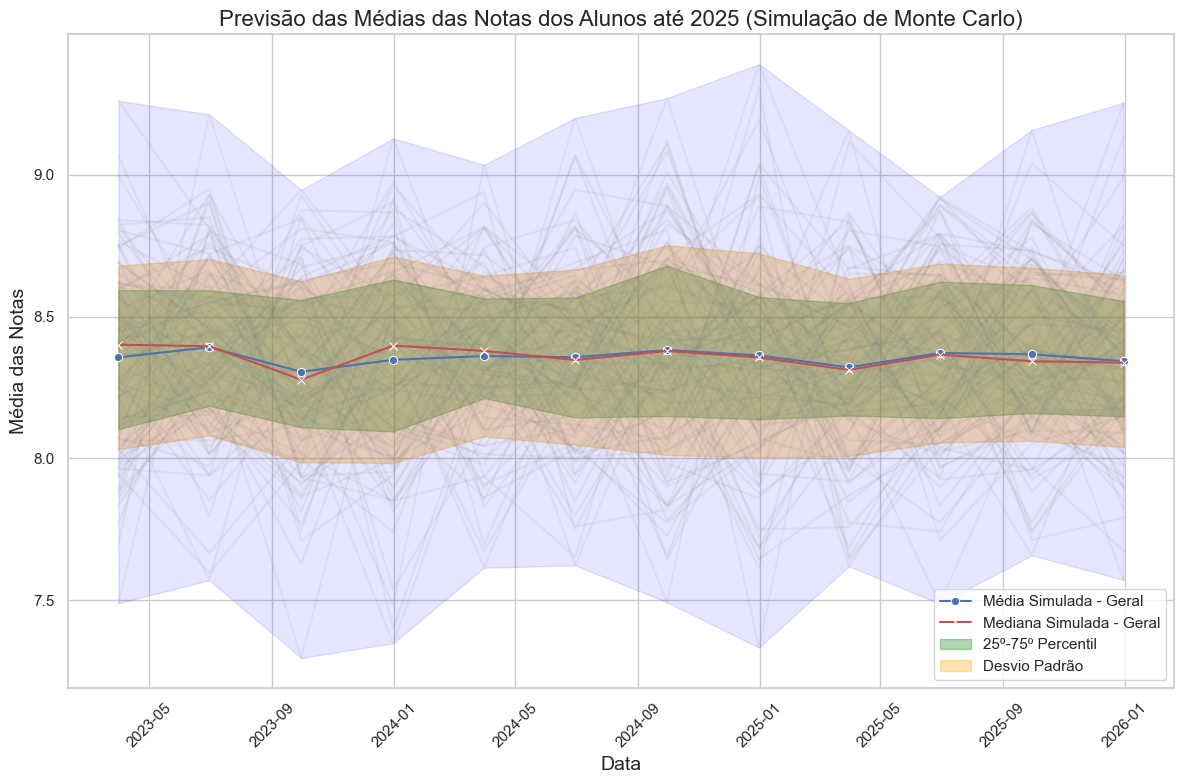

In [9]:
# this is the SQL text that will be executed
sql_text = """
SELECT DATA, MEDIAS_DOS_ALUNOS, PERIODO FROM RM99210.Historico_Notas
WHERE EXTRACT(YEAR FROM DATA) = 2022
"""

# here we create a python connection,cursor object and execute the statement using  Cursor.execute().
# connections and cursors should be released when they are no longer needed.
# closed automatically when the variable referencing it goes out of scope (and no further references are retained).
# `with` block is a convenient way to ensure this
with oracledb.connect(
 user='RM99667',
  password='260903',
  dsn='oracle.fiap.com.br:1521/ORCL',
  config_dir='C:\\Users\\victo\\Oracle\\network\\admin',
) as connection:
    with connection.cursor() as cursor:
        # Fetch all rows from the executed query
        rows = cursor.execute(sql_text).fetchall()
        # Fetch column names
        column_names = [col[0] for col in cursor.description]

# Convert the data to a DataFrame
df = pd.DataFrame(rows, columns=column_names)

# Ensure the 'DATA' column is in datetime format
df['DATA'] = pd.to_datetime(df['DATA'])

# Ensure the 'MEDIAS_DOS_ALUNOS' column is numeric
df['MEDIAS_DOS_ALUNOS'] = pd.to_numeric(df['MEDIAS_DOS_ALUNOS'], errors='coerce')

# Drop rows with NaN values in 'MEDIAS_DOS_ALUNOS'
df = df.dropna(subset=['MEDIAS_DOS_ALUNOS'])

# Separate data for morning, night, and general periods
df_morning = df[df['PERIODO'] == 'Manhã']
df_night = df[df['PERIODO'] == 'Noite']
df_general = df  # All data

# Group by 'DATA' and calculate the mean of 'MEDIAS_DOS_ALUNOS' for each period
df_morning_grouped = df_morning.groupby('DATA')['MEDIAS_DOS_ALUNOS'].mean().reset_index()
df_night_grouped = df_night.groupby('DATA')['MEDIAS_DOS_ALUNOS'].mean().reset_index()
df_general_grouped = df_general.groupby('DATA')['MEDIAS_DOS_ALUNOS'].mean().reset_index()

# Extract the mean and standard deviation of the 2022 data for each period
mean_morning_2022 = df_morning_grouped['MEDIAS_DOS_ALUNOS'].mean()
std_morning_2022 = df_morning_grouped['MEDIAS_DOS_ALUNOS'].std()

mean_night_2022 = df_night_grouped['MEDIAS_DOS_ALUNOS'].mean()
std_night_2022 = df_night_grouped['MEDIAS_DOS_ALUNOS'].std()

mean_general_2022 = df_general_grouped['MEDIAS_DOS_ALUNOS'].mean()
std_general_2022 = df_general_grouped['MEDIAS_DOS_ALUNOS'].std()

# Define the number of simulations and the number of periods (quarters) until 2025
num_simulations = 100
num_periods = (2025 - 2022) * 4  # 4 quarters per year

# Perform Monte Carlo simulation for morning period with a 10% increase
simulations_morning = np.zeros((num_simulations, num_periods))
for i in range(num_simulations):
    simulated_values = np.random.normal(mean_morning_2022, std_morning_2022, num_periods)
    simulations_morning[i, :] = simulated_values * 1.10  # Apply 10% increase

# Perform Monte Carlo simulation for night period with a 10% increase
simulations_night = np.zeros((num_simulations, num_periods))
for i in range(num_simulations):
    simulated_values = np.random.normal(mean_night_2022, std_night_2022, num_periods)
    simulations_night[i, :] = simulated_values * 1.10  # Apply 10% increase

# Perform Monte Carlo simulation for general period with a 10% increase
simulations_general = np.zeros((num_simulations, num_periods))
for i in range(num_simulations):
    simulated_values = np.random.normal(mean_general_2022, std_general_2022, num_periods)
    simulations_general[i, :] = simulated_values * 1.10  # Apply 10% increase

# Calculate the mean, median, percentiles, and standard deviation of the simulations for each period
mean_simulations_morning = simulations_morning.mean(axis=0)
median_simulations_morning = np.median(simulations_morning, axis=0)
percentile_25_morning = np.percentile(simulations_morning, 25, axis=0)
percentile_75_morning = np.percentile(simulations_morning, 75, axis=0)
std_simulations_morning = simulations_morning.std(axis=0)

mean_simulations_night = simulations_night.mean(axis=0)
median_simulations_night = np.median(simulations_night, axis=0)
percentile_25_night = np.percentile(simulations_night, 25, axis=0)
percentile_75_night = np.percentile(simulations_night, 75, axis=0)
std_simulations_night = simulations_night.std(axis=0)

mean_simulations_general = simulations_general.mean(axis=0)
median_simulations_general = np.median(simulations_general, axis=0)
percentile_25_general = np.percentile(simulations_general, 25, axis=0)
percentile_75_general = np.percentile(simulations_general, 75, axis=0)
std_simulations_general = simulations_general.std(axis=0)

# Create a date range for the periods
date_range = pd.date_range(start='2023-03-01', periods=num_periods, freq='3M')

# Set the Seaborn style
sns.set(style="whitegrid")

# Plotting the results for morning period using Seaborn
plt.figure(figsize=(12, 8))
for i in range(num_simulations):
    sns.lineplot(x=date_range, y=simulations_morning[i, :], color='gray', alpha=0.1)
sns.lineplot(x=date_range, y=mean_simulations_morning, marker='o', linestyle='-', color='b', label='Média Simulada - Manhã')
sns.lineplot(x=date_range, y=median_simulations_morning, marker='x', linestyle='-', color='r', label='Mediana Simulada - Manhã')
plt.fill_between(date_range, percentile_25_morning, percentile_75_morning, color='green', alpha=0.3, label='25º-75º Percentil')
plt.fill_between(date_range, mean_simulations_morning - std_simulations_morning, mean_simulations_morning + std_simulations_morning, color='orange', alpha=0.3, label='Desvio Padrão')
plt.fill_between(date_range, simulations_morning.min(axis=0), simulations_morning.max(axis=0), color='blue', alpha=0.1)
plt.title('Previsão das Médias das Notas dos Alunos da Manhã até 2025 (Simulação de Monte Carlo)', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Média das Notas', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plotting the results for night period using Seaborn
plt.figure(figsize=(12, 8))
for i in range(num_simulations):
    sns.lineplot(x=date_range, y=simulations_night[i, :], color='gray', alpha=0.1)
sns.lineplot(x=date_range, y=mean_simulations_night, marker='o', linestyle='-', color='b', label='Média Simulada - Noite')
sns.lineplot(x=date_range, y=median_simulations_night, marker='x', linestyle='-', color='r', label='Mediana Simulada - Noite')
plt.fill_between(date_range, percentile_25_night, percentile_75_night, color='green', alpha=0.3, label='25º-75º Percentil')
plt.fill_between(date_range, mean_simulations_night - std_simulations_night, mean_simulations_night + std_simulations_night, color='orange', alpha=0.3, label='Desvio Padrão')
plt.fill_between(date_range, simulations_night.min(axis=0), simulations_night.max(axis=0), color='blue', alpha=0.1)
plt.title('Previsão das Médias das Notas dos Alunos da Noite até 2025 (Simulação de Monte Carlo)', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Média das Notas', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
for i in range(num_simulations):
    sns.lineplot(x=date_range, y=simulations_general[i, :], color='gray', alpha=0.1)
sns.lineplot(x=date_range, y=mean_simulations_general, marker='o', linestyle='-', color='b', label='Média Simulada - Geral')
sns.lineplot(x=date_range, y=median_simulations_general, marker='x', linestyle='-', color='r', label='Mediana Simulada - Geral')
plt.fill_between(date_range, percentile_25_general, percentile_75_general, color='green', alpha=0.3, label='25º-75º Percentil')
plt.fill_between(date_range, mean_simulations_general - std_simulations_general, mean_simulations_general + std_simulations_general, color='orange', alpha=0.3, label='Desvio Padrão')
plt.fill_between(date_range, simulations_general.min(axis=0), simulations_general.max(axis=0), color='blue', alpha=0.1)
plt.title('Previsão das Médias das Notas dos Alunos até 2025 (Simulação de Monte Carlo)', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Média das Notas', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------------------------------------
# Área do Aluno e suas funcionalidades
--------------------------------------------------------------------------------------------------------------

### Consulta de notas 

Este código consulta a nota de um aluno no banco de dados Oracle e a exibe junto com a data da avaliação. Usando ipywidgets, o usuário insere o nome do aluno e, ao clicar no botão "Check Grade", a função display_grade busca as informações no banco de dados. Se a nota for encontrada, ela é exibida; caso contrário, uma mensagem de erro é mostrada. O código também trata possíveis erros de conexão com o banco de dados.

In [10]:
# Função para exibir a nota do aluno e a data
def display_grade(nome_aluno):
    try:
        # Conectar ao banco de dados Oracle
        with oracledb.connect(
            user='RM99667',
            password='260903',
            dsn='oracle.fiap.com.br:1521/ORCL',
            config_dir='C:\\Users\\victo\\Oracle\\network\\admin',
        ) as connection:
            # Criar um cursor para executar a consulta SQL
            with connection.cursor() as cursor:
                # Executar a consulta SQL para obter a nota do aluno e a data
                cursor.execute("""
                    SELECT DATA, MEDIAS_DOS_ALUNOS FROM RM99210.Historico_Notas
                    WHERE NOME_ALUNO = :1
                """, (nome_aluno,))
                # Obter o resultado da consulta
                result = cursor.fetchone()
                # Verificar se a nota foi encontrada
                if result:
                    data, media = result
                    print(f"Date: {data}, Your grade is: {media}")
                else:
                    print("No grade found for this student name.")
    except oracledb.DatabaseError as e:
        # Capturar e exibir erros de banco de dados
        error, = e.args
        print(f"Database error: {error.message}")

# Widgets para o nome do aluno
nome_aluno_widget = widgets.Text(description='Student Name:')
check_grade_button = widgets.Button(description='Check Grade')
error_label = widgets.Label(value='', layout=widgets.Layout(color='red'))

# Função para lidar com o clique do botão de verificar nota
def on_check_grade_button_clicked(b):
    nome_aluno = nome_aluno_widget.value.strip()
    
    # Verificar se o campo de nome do aluno está preenchido
    if not nome_aluno:
        error_label.value = "Por favor, preencha o campo de nome do aluno."
        return
    
    error_label.value = ''  # Clear any previous error message
    display_grade(nome_aluno)

# Anexar o evento de clique ao botão de verificar nota
check_grade_button.on_click(on_check_grade_button_clicked)

# Exibir os widgets
display(nome_aluno_widget, check_grade_button, error_label)

Text(value='', description='Student Name:')

Button(description='Check Grade', style=ButtonStyle())

Label(value='')

### Verificar descrição dos jogos 
Este código permite consultar e exibir as descrições de um jogo no banco de dados Oracle. Utilizando ipywidgets, o usuário insere o nome do jogo e, ao clicar no botão "Check Game", a função display_game_descriptions é chamada para buscar as informações. Os resultados são exibidos em formato de tabela, incluindo o ID do jogo, tipo, dificuldade, data de lançamento e descrição. Se o jogo não for encontrado, uma mensagem de erro é mostrada, e o código também trata erros de conexão com o banco de dados.

In [11]:
# Função para exibir as descrições do jogo
def display_game_descriptions(nome_jogo):
    try:
        # Conectar ao banco de dados Oracle
        with oracledb.connect(
            user='RM99667',
            password='260903',
            dsn='oracle.fiap.com.br:1521/ORCL',
            config_dir='C:\\Users\\victo\\Oracle\\network\\admin',
        ) as connection:
            # Criar um cursor para executar a consulta SQL
            with connection.cursor() as cursor:
                # Executar a consulta SQL para obter as descrições do jogo
                cursor.execute("""
                    SELECT ID_JOGO, TP_JOGO, NR_DIFICULDADE, DT_LANCAMENTO, DS_JOGO, NOME
                    FROM RM99210.JOGO
                    WHERE TRIM(UPPER(NOME)) = TRIM(UPPER(:1))
                """, (nome_jogo,))
                # Obter todos os resultados da consulta
                results = cursor.fetchall()
                # Verificar se algum resultado foi encontrado
                if results:
                    # Exibir os resultados em formato de tabela
                    display(HTML(tabulate(results, headers=['ID_JOGO', 'TP_JOGO', 'NR_DIFICULDADE', 'DT_LANCAMENTO', 'DS_JOGO', 'NOME'], tablefmt='html')))
                else:
                    print("No game found with this name.")
    except oracledb.DatabaseError as e:
        # Capturar e exibir erros de banco de dados
        error, = e.args
        print(f"Database error: {error.message}")

# Widgets para o nome do jogo
nome_jogo_widget = widgets.Text(description='Game Name:')
check_game_button = widgets.Button(description='Check Game')
error_label = widgets.Label(value='', layout=widgets.Layout(color='red'))

# Função para lidar com o clique do botão de verificar jogo
def on_check_game_button_clicked(b):
    nome_jogo = nome_jogo_widget.value.strip()
    
    # Verificar se o campo de nome do jogo está preenchido
    if not nome_jogo:
        error_label.value = "Por favor, preencha o campo de nome do jogo."
        return
    
    error_label.value = ''  # Clear any previous error message
    display_game_descriptions(nome_jogo)

# Anexar o evento de clique ao botão de verificar jogo
check_game_button.on_click(on_check_game_button_clicked)

# Exibir os widgets
display(nome_jogo_widget, check_game_button, error_label)

Text(value='', description='Game Name:')

Button(description='Check Game', style=ButtonStyle())

Label(value='')